In [2]:
# !pip install PyTDC
# !git clone https://github.com/chemprop/chemprop
# !pip install rdkit-pypi
# !pip install mendeleev
# !pip install chemprop

In [1]:
from tdc.single_pred import Tox
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import mendeleev

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

print(chemprop.__file__)

# from google.colab import drive

/Users/dawnxi/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/chemprop/__init__.py


In [4]:
# # Mount google drive.
# drive.mount('/content/drive')
# mydrive = '/content/drive/MyDrive'

In [2]:
# Get toxicity data and write to output. 
data = Tox(name = 'LD50_Zhu')
df = data.get_data()
split = data.get_split()
df.to_csv('./Tox.csv', index=False)

Found local copy...
Loading...
Done!


In [6]:
# Train on tox data with default parameters. 
arguments = [
    '--data_path', './Tox.csv',
    '--dataset_type', 'regression',
    '--smiles_columns', 'Drug',
    '--target_columns', 'Y',
    '--save_dir', 'test_checkpoints_reg',
    '--epochs', '5']

args = chemprop.args.TrainArgs().parse_args(arguments)
# print(chemprop.args)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)


Command line
python /Users/dawnxi/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9018 --control=9016 --hb=9015 --Session.signature_scheme="hmac-sha256" --Session.key=b"4ed005b7-9b67-411a-8fcc-2a679c3f131c" --shell=9017 --transport="tcp" --iopub=9019 --f=/Users/dawnxi/Library/Jupyter/runtime/kernel-v2-71499486bTJ7RvJaq.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': Non

KeyboardInterrupt: 

In [27]:
# Create physical features 
smiles = df['Drug']

atom_numbers = [*range(1,100)]
envs_list = np.array([0]+[mendeleev.element(i).en_pauling for i in atom_numbers])
radii_list = np.array([0]+[mendeleev.element(i).atomic_radius for i in atom_numbers])
polar_list = np.array([0]+[mendeleev.element(i).dipole_polarizability for i in atom_numbers])
elaff_list = np.array([0]+[mendeleev.element(i).electron_affinity for i in atom_numbers])
ionen_list = np.array([0]+[mendeleev.element(i).ionenergies[1] for i in atom_numbers])

radii = []
envs = []
polar = []
elaff = []
ionen = []
for SMILES in smiles:

  mol = Chem.MolFromSmiles(SMILES)
  atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
  radii.append([radii_list[i] for i in atoms])
  envs.append([envs_list[i] for i in atoms])
  polar.append([polar_list[i] for i in atoms])
  elaff.append([elaff_list[i] for i in atoms])
  ionen.append([ionen_list[i] for i in atoms])

ar = []
for r,e,p,el,io in zip(radii, envs, polar, elaff, ionen):
  ar.append(np.vstack([np.array(r), np.array(e), np.array(p), np.array(el), np.array(io)]).T)

# Save physical features.
np.savez('dsc.npz', *ar)

# Create functional group features.
def get_indices_of_functional_groups(mol, smarts_pattern):
    """
    Returns the indices of atoms in a molecule that match a specified functional group pattern.
    If there are multiple matches, all the matches are returned as individual lists.

    :param mol: A molecule.
    :param smarts_pattern: A SMARTS pattern.
    :return: A nested list of atom indices, where each inner list corresponds to a single match.
    """
    
    pattern = Chem.MolFromSmarts(smarts_pattern)
    # find all matches to the pattern.
    occurance_list = []
    for i, match in enumerate(mol.GetSubstructMatches(pattern)):
        indices = []
        for j in match:
            mol.GetAtomWithIdx(j).SetProp('feature', str(i + 1))
            indices.append(j)
        occurance_list.append(indices)
    return occurance_list

# How to run the function above.
# print(get_indices_of_functional_groups(Chem.MolFromSmiles('CC(CS)C(=O)N1CCCC1C(=O)O'), '[CX3]=[OX1]'))

# Read in tab separated file of smarts patterns and functional group names
fg = pd.read_csv('./SMARTS_functional_groups_upd2.txt', sep='\t')

# Make a hash table of the reactivity. 
reactivity_dict = {}
for i, row in fg.iterrows():
    reactivity_dict[row['Description']] = row['REACTIVITY']
# Also make a hash table of the H_RELEVANT column.
h_relevant_dict = {}
for i, row in fg.iterrows():
    h_relevant_dict[row['Description']] = row['H_RELEVANT']

functional_groups_feature_all = []
reactivity_feature_all = []
h_relevant_feature_all = []

for SMILES in smiles:
    mol = Chem.MolFromSmiles(SMILES)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    num_atoms = len(atoms)
    # Create a list of the atom indices that match the SMARTS pattern and 0's for the rest.
    
    all_functional_groups = []
    all_reactivity = []
    all_h_relevant = []

    for i, row in fg.iterrows():
        SMARTS = row['SMARTS']
        functional_group = np.zeros(num_atoms)
        reactivity = np.zeros(num_atoms)
        h_relevant = np.zeros(num_atoms)

        # Get the indices of atoms that match the SMARTS pattern.
        indices = get_indices_of_functional_groups(mol, SMARTS)
        
        for j, index_list in enumerate(indices):
            for atom in index_list:
                functional_group[atom] = j + 1
                reactivity[atom] = reactivity_dict[row['Description']]
                h_relevant[atom] = h_relevant_dict[row['Description']]

        # if len(indices) > 0:
        #     print(row['Description'])
        #     print(functional_group)
        #     display(mol)

        all_functional_groups.append(functional_group)
        all_reactivity.append(reactivity)
        all_h_relevant.append(h_relevant)
    
    all_functional_groups = np.vstack(all_functional_groups).T
    functional_groups_feature_all.append(all_functional_groups)
    all_reactivity = np.vstack(all_reactivity).T
    reactivity_feature_all.append(all_reactivity)
    all_h_relevant = np.vstack(all_h_relevant).T
    h_relevant_feature_all.append(all_h_relevant)
print(h_relevant_feature_all)
# # Save the data
np.savez('fngr.npz', *functional_groups_feature_all)
np.savez('h_relevant.npz', *h_relevant_feature_all)
np.savez('reactivity.npz', *reactivity_feature_all)

Amide
[0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


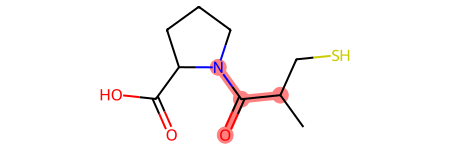

Carboxylic acid or conjugate base
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


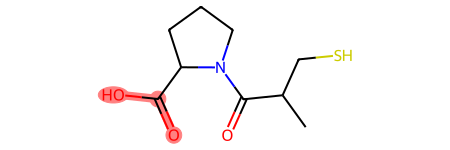

Hydroxyl in Carboxylic Acid
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


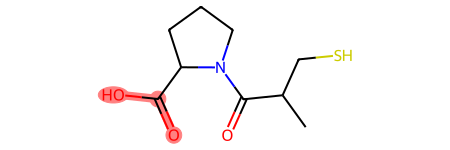

Thiol
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


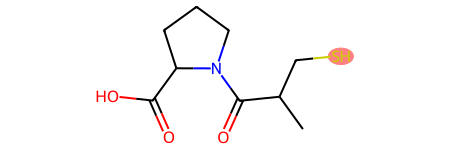

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [ ]:
# Concate physical group and functional group features for atoms. 
all = ar + functional_groups_feature_all + reactivity_feature_all + h_relevant_feature_all
np.savez('all.npz', *all)

In [ ]:
# Run with atom physical descriptors. 
arguments = [
    '--data_path', '../Tox.csv',
    '--dataset_type', 'regression',
    '--smiles_columns', 'Drug',
    '--target_columns', 'Y',
    '--save_dir', 'test_checkpoints_reg',
    '--epochs', '5']

args = chemprop.args.TrainArgs().parse_args(arguments)
# print(chemprop.args)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
print(mean_score, std_score)

In [ ]:
# Run with atom physical descriptors, override existing descriptors. 
arguments = [
    '--data_path', '../Tox.csv',
    '--dataset_type', 'regression',
    '--smiles_columns', 'Drug',
    '--target_columns', 'Y',
    '--save_dir', 'test_checkpoints_reg',
    '--epochs', '5',
    '--atom_descriptors', 'descriptor',
    '--atom_descriptors_path', './dsc.npz',
    '--overwrite_default_atom_features', 'True']


args = chemprop.args.TrainArgs().parse_args(arguments)
# print(chemprop.args)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
print(mean_score, std_score)

Command line
python /usr/local/bin/chemprop_train --data_path Tox.csv --dataset_type regression --smiles_column Drug --target_columns Y --save_dir ./ --atom_descriptors descriptor --atom_descriptors_path ./dsc.npz
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'descriptor',
 'atom_descriptors_path': './dsc.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': True,
 'data_path': 'Tox.csv',
 'data_weights_path': None,
 'dataset_type': 'regre

In [ ]:
!chemprop_train --data_path 'Tox.csv' --dataset_type 'regression' \
 --smiles_column 'Drug' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './dsc.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Tox.csv --dataset_type regression --smiles_column Drug --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./dsc.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './dsc.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': True,
 'data_path': 'Tox.csv',
 'data_weights_path': N